In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial C2: Plotting

A crucial component of conveying what a model has learned is creating visuals of its findings. A gap in the visualization ecosystem is the production of plots showing per-character weights (called logo plots). Some packages, such as `logomaker`, provide core functionality but can require a bit of additional boilerplate code at each call. Accordingly, `tangermeme` provides some basic plotting tools that cover making the logo plot itself as well as annotating the plot with important sites. These plots are not meant to be the most aesthetically appealing but rather to aid in the discovery process. We will see how these plots can be used to display both the observed and the hypothetical attribution values.

#### Logo Plots

Simply, logo plots are those where characters are shown in a sequence and the height of those characters correspond to some meaningful quantity. These can be made using the `plot_logo` function which requires an art board to plot on and a `(len(alphabet), length)` tensor of values. There are several additional optional parameters that we will explore as well.

We can start off by just trying to plot a one-hot encoding. Basically, at each position, the observed character will have a weight of 1. When making these plots, I like to use the `whitegrid` style from seaborn because I find it to be aesthetically pleasant.

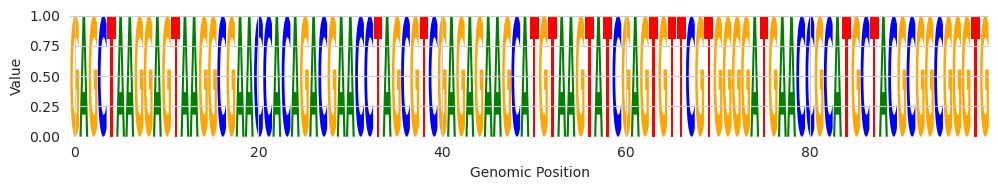

In [2]:
from tangermeme.utils import random_one_hot
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

X = random_one_hot((1, 4, 2000), random_state=0)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Position")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

There are a few notes to be aware of here. The first is that you can continue to annotate the artboard that has the logo on it using stnadard matplotlib commands. The `plot_logo` function itself will not add x- or y-labels or titles or anything else. It will just create the central panel. The second is that the color default for `logomaker`, which is what the `plot_logo` function is wrapping, is what you are seeing above. The third is that you must create a subplot as shown above and pass that artboard into the `plot_logo` function. As a final note, you should be careful about the amount of sequence you are visualizing. Making these plots is more time consuming than one might expect (not a crazy amount of time, but just more than you might expect) and if too many characters are visualized it may be challenging to actually make out their heights or the motifs they are comprising.

Past these notes, the result is exactly what one might expect. Given a one-hot encoding, the `logo` displays the characters that are observed at a uniform height of 1.

However, we do not have to only plot one character per position. If we want to plot values for multiple characters at each position, all we need to do is pass in values for multiple characters at those positions. As a concrete example, let's just set all the values for the middle position in the sequence to 1 and see what happens.

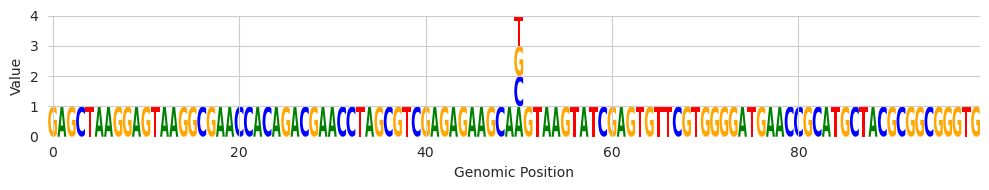

In [3]:
import torch

X2 = torch.clone(X)
X2[0, :, 1000] = 1

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X2[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Position")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

Unsurprisingly, we see that at that one position now each character has a value of 1 and is stacked on top of each other. As a more extreme example, what happens if we just plot random values? 

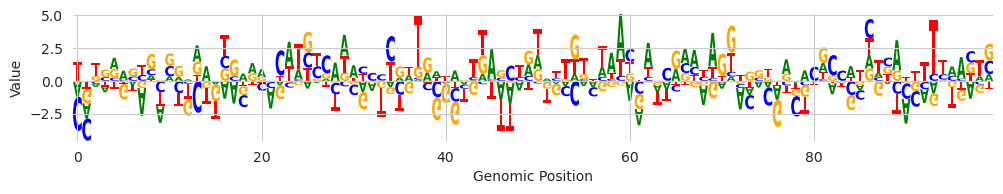

In [4]:
torch.manual_seed(0)
X3 = torch.randn(4, 100)

plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X3, ax=ax)

plt.xlabel("Genomic Position")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

An important note about these plots is that characters are first partitioned into positive and negative attributions and positive characters are stacked above 0 and negative characters are stacked, upside-down, below 0. Their ordering in the stack is equal to their value, with the largest values appearing on the top (or on the bottom in the negative stack).

#### Attribution Logo Plots

Perhaps the most relevant values to be displaying in a logo plot are the per-character attribution values from a model. Naturally, after calculating these values and having the intuition that they are highlighting motifs that are driving model predictions, one would want to see by eye what motifs are popping out to get a better sense for what is driving predictions in the system. We can demonstrate this using the Beluga model.

In [5]:
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

We can then add an AP-1 motif into the middle of our sequence of interest and use `deep_lift_shap` to calculate attributions for one of the AP-1 protein binding tasks. Intuitively, this should lead to attributions highlighting the motif of interest.

In [6]:
from tangermeme.ersatz import substitute
from tangermeme.deep_lift_shap import deep_lift_shap

X = substitute(X, "CTCAGTGATG")
X_attr = deep_lift_shap(model, X, target=267, device='cpu')

Now, we can plot these attributions just like we plotted the one-hot encodings and random values before.

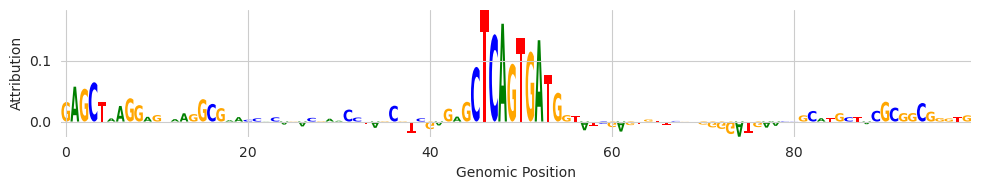

In [7]:
plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")

plt.tight_layout()
plt.show()

As expected, the model attributions highlight the AP-1 motif that was added. Using only a few commands you get now get attributions for any model at a locus and plot them.

#### Coloring the Characters

If you don't like the default coloring scheme you can pass in your own color using the `color` parameter. Right now, this will assign the same color to every character, but it can be useful when comparing attributions at the same locus across several models that are each colored differently, or when you are displaying different motifs and want to color them according to some other label.

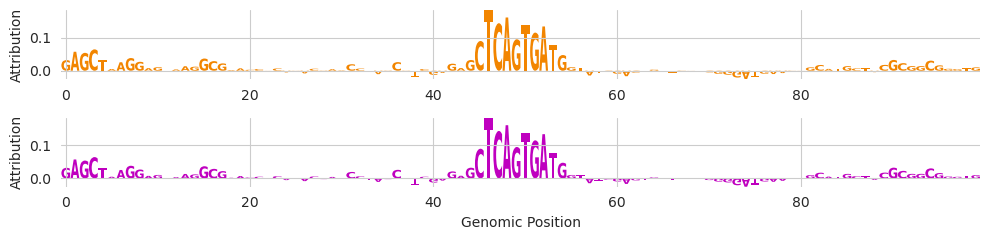

In [8]:
plt.figure(figsize=(10, 2.5))
ax = plt.subplot(211)
plot_logo(X_attr[0, :, 950:1050], ax=ax, color='#F28500')
plt.ylabel("Attribution")

ax = plt.subplot(212)
plot_logo(X_attr[0, :, 950:1050], ax=ax, color='m')

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")

plt.tight_layout()
plt.show()

#### Annotating a Logo Plot

Frequently when looking at these plots it can be useful to include sequence annotations to help explain what is happening. Basically, when looking at a span of highlighted characters it can be challenging to know what the span correspondings to, e.g., what protein binding site those characters correspond to. Actually, these sort of plot can be *more* useful when *multiple* binding sites appear close by or *even overlapping* with each other. If you restrict yourself to only looking at one sort of protein binding site you may miss something important happening nearby. 

Regardless, the annotations must be a pandas DataFrame in BED format. Specifically, the columns of the annotation must have the columns `name start end strand score` where the name can be the chromosome or it can be something more informative, such as the name of the motif, and both start and end are 0-indexed. Currently, `strand` is not used in the plot but this might change in the future. The score refers to some notion of confidence or importance or strength of the annotation and will displayed but also used to order annotations that overlap. Additional columns can be included in the DataFrame but they will be ignored.

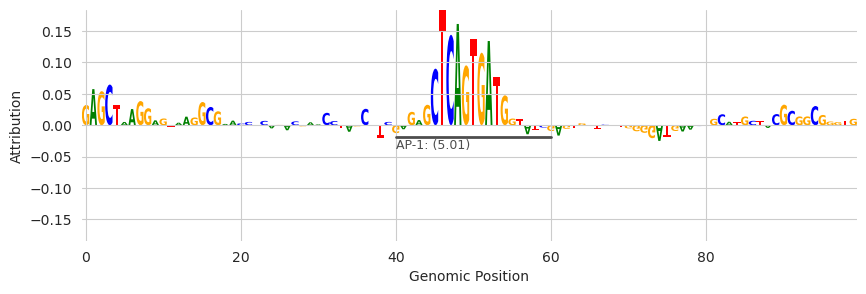

In [9]:
import pandas

annotations = pandas.DataFrame({
    'name': ['AP-1'], 
    'start': [990], 
    'end': [1010], 
    'strand': ['.'],  # Not necessary
    'score': [5.01],  # Just a random number 
})
    
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=annotations)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

Sometimes, annotations overlap each other. By default, I have tried to make these be displayed in a smart manner that does not get confused by scores or overlap. Basically, the process is that multiple "rows" of annotations are kept track of and if the annotations -- in order of strength of signal -- can fit in the first track of annotations it will be put there, even if a previously placed motif with a higher strength has been put in the second track of annotations. Take a look at what happens wiht Test2 and Test3 in the below annotations.

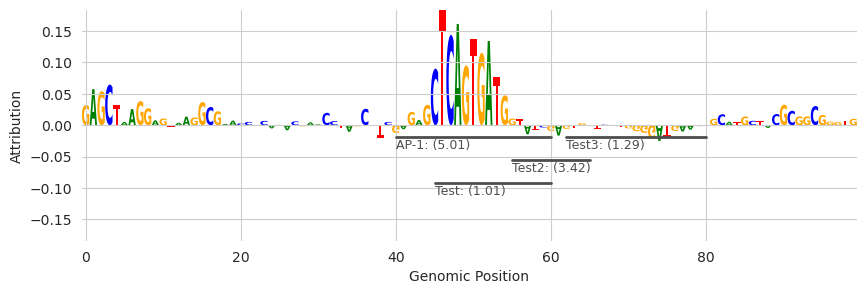

In [10]:
annotations = pandas.DataFrame({
    'name': ['AP-1', 'Test', 'Test2', 'Test3'], 
    'start': [990, 995, 1005, 1012], 
    'end': [1010, 1010, 1015, 1030], 
    'strand': ['.', '.', '.', '.'],  # Not necessary
    'score': [5.01, 1.01, 3.42, 1.29],  # Just a random number 
})
    
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=annotations)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

This greedy process of placing annotations results in a fairly well-packed set of annotations. One could imagine a simpler strategy being confused by Test2 and Test3 and deciding that Test3 should go below Test2 because it has a lower score and overlaps with Test2. However, this process *is* greedy and so may make mistakes in some situations, but generally it is pretty good.

Eventually, these tracks will run off the edge of the plot. I do not yet have a complete solution for this but, by default, after four rows of annotations have been plotted a simpler representation that is just the name of the motif hit will be placed so that more can fit in the plot. We can see an example of this by just copying each of the motifs a second time so that we get six motifs on top of each other.

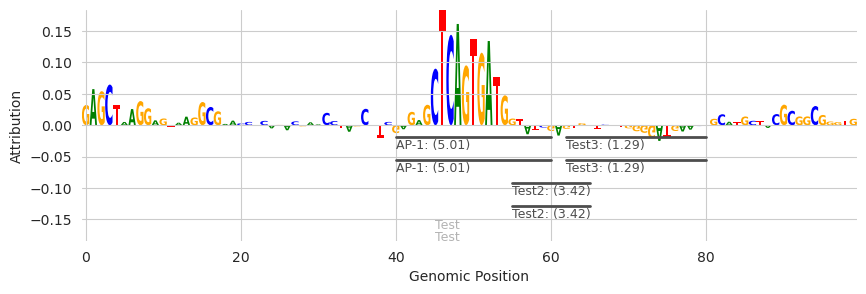

In [11]:
annotations = pandas.DataFrame({
    'name': ['AP-1', 'Test', 'Test2', 'Test3', 'AP-1', 'Test', 'Test2', 'Test3'], 
    'start': [990, 995, 1005, 1012, 990, 995, 1005, 1012], 
    'end': [1010, 1010, 1015, 1030, 1010, 1010, 1015, 1030], 
    'strand': ['.', '.', '.', '.', '.', '.', '.', '.'],  # Not necessary
    'score': [5.01, 1.01, 3.42, 1.29, 5.01, 1.01, 3.42, 1.29],  # Just a random number 
})
    
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=annotations)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

The two motif hits for "Test" are more compact than the others and in a lighter gray color.

If we want to hide these additional annotations rather than displaying them in a more compact manner, we can pass in the `show_extra=False`.

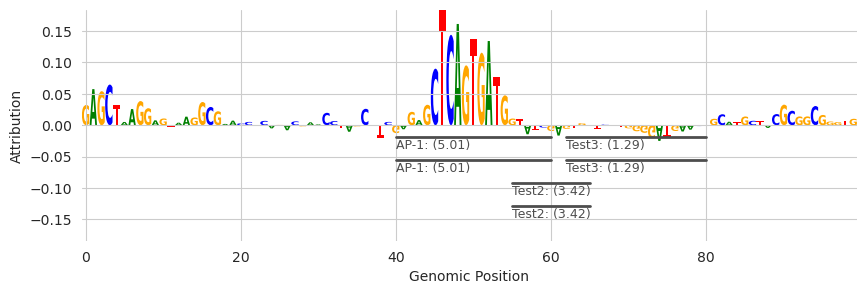

In [12]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=annotations, show_extra=False)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

Note that the light gray "Test" annotations are gone.

We can also control the number of tracks that are displayed before switching to the more compressed representation.

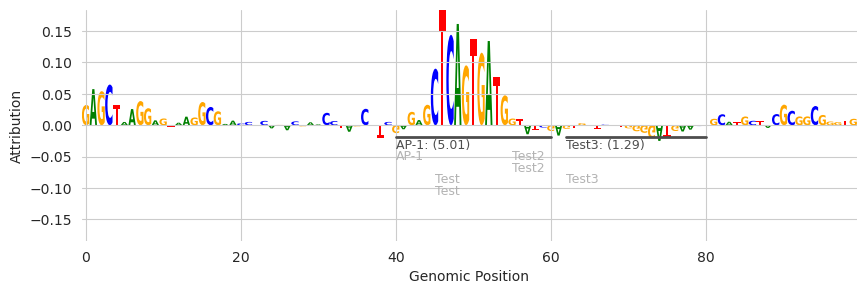

In [13]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=annotations, n_tracks=1)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

#### Annotations from FIMO

A simple way to get these annotations is by running a motif scanner, such as FIMO, using some previously-determined set of motifs. These annotations would then be derived solely from sequence match without considering attribution scores and so can be a somewhat-orthogonal set of information when considering these sequences and the attributions.

Please see the tutorial on FIMO for a complete description but, briefly, you use the FIMO implementation by passing in a dictionary of motifs where the keys are names of motifs and the values are PyTorch tensors containing the PWM. The object has several methods but the most relevant one for generating attributions is the `hits` method, which will score each motif hit at each position in the sequence, convert the scores into p-values given the length of the motif and its information content, and then return only those positions that pass the threshold.

In [14]:
from tangermeme.utils import one_hot_encode
from tangermeme.tools.fimo import FIMO

motifs = {'AP-1': one_hot_encode("CTCAGTGATG").T}        # For this example we only care about one sequence.
annotations = FIMO(motifs).hits(X, dim=1, device='cpu')  # Scan a set of motifs against the genome
annotations[0]

1it [00:00, 3474.98it/s]


,motif,start,end,strand,score,attr,seq
0,AP-1,995,1005,+,13.863442,.,CTCAGTGATG


Given that the annotations are already in the proper format, we can just pass them into the same plotting function as before.

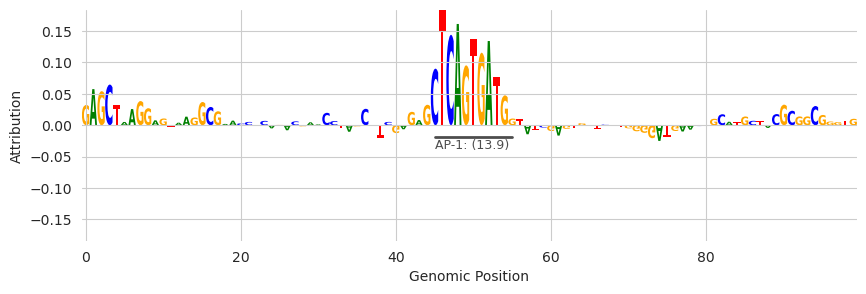

In [15]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=annotations[0], n_tracks=1)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

The result looks similar. The key from the original dictionary of motifs is now displayed under the bar, the number is the FIMO score associated with that hit (not a p-value or log p-value) and the span extends from the beginning of the hit to the end of the hit according to FIMO.

#### Annotations from Seqlets

An alternative method for getting annotations is to identify spans of high attribution that are agnostic to the actual sequences that have those high attribution values. Basically, rather than looking solely at nucleotide sequence you can look solely at attribution values. These spans are usually called "seqlets" and you can read more about them in the tutorial specifically about seqlets. However, all you need to know here is that `tfmodisco_seqlets` returns two pandas DataFrames where one corresponds to seqlets with positive attribution and one refers to those with low attribution.

In [16]:
from tangermeme.seqlet import tfmodisco_seqlets


pos_seqlets, neg_seqlets = tfmodisco_seqlets(X_attr)
pos_seqlets

,example_idx,start,end,strand,score,attr,seq
0,0,976,1017,*,1.259735,1.259735,CGTCGAGAGCTCAGTGATGGT
1,0,937,978,*,0.610837,0.610837,GCTGAGCTAAGGAGTAAGGCG
2,0,1030,1071,*,0.337327,0.337327,GCGGCGGGTGCGGGTGACCTA


In this case the `score` and `attr` columns are the same because they are both based on attribution value. Another notable difference is that, rather than having motif names in the first column, you have the example index from the set of attribution values you passed in. Despite these small differences, we can still pass them in to the same function.

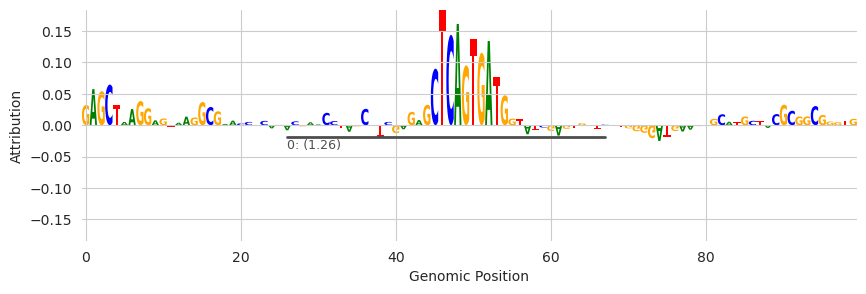

In [17]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=pos_seqlets, n_tracks=1)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

One caveat being that the seqlet dataframe contains seqlets from every example that you called seqlets on. If you only called seqlets on one example (the one being plotted) this is fine. Otherwise, you'll need to partition the data into seqlets from just the example you are operating on.

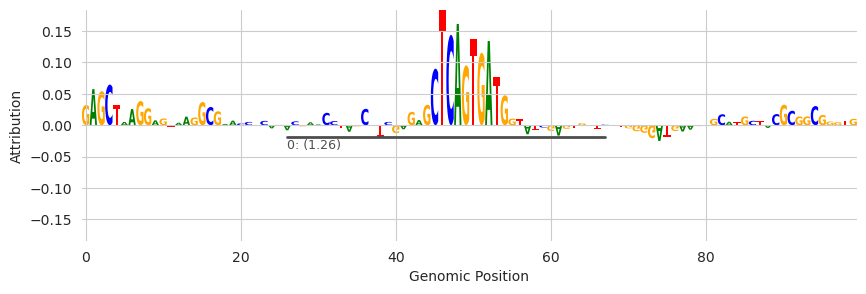

In [18]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=950, end=1050, annotations=pos_seqlets[pos_seqlets['example_idx'] == 0], n_tracks=1)

plt.xlabel("Genomic Position")
plt.ylabel("Attribution")
plt.show()

Here, all of the called seqlets are from `example_idx=0` but the above code is what you would use if you did have multiple seqlets.